In [2]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time

# for visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
import seaborn as sns


In [3]:
# Extract Raw data
PATH = os.path.expanduser("~/investor/data/raw")
all_files = glob.glob(os.path.join(PATH , "*.csv"))

all_df = []

for filename in all_files:
    file = pd.read_csv(filename, index_col=None, header=0)
    all_df.append(file)
    
df = pd.concat(all_df, axis=0, ignore_index=True)

# Renaming the columns by removing the '<' and '>' characters
new_column_names = {col: col.strip('<>').upper() for col in df.columns}
df = df.rename(columns=new_column_names)

# changing the integer dates to datetime format, taking 2002- NOW:
df = df[np.logical_and(df['DATE'] <= '2024-01-01', df['DATE'] > '2001-12-31')]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5537 entries, 0 to 5536
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    5537 non-null   object 
 1   OPEN    5537 non-null   float64
 2   HIGH    5537 non-null   float64
 3   LOW     5537 non-null   float64
 4   CLOSE   5537 non-null   float64
 5   VOLUME  5537 non-null   float64
dtypes: float64(5), object(1)
memory usage: 302.8+ KB


In [4]:
# OHLC prices: These are essential for technical analysis and commonly used to derive various technical indicators.
# Volume: Trading volume provides insights into market activity and liquidity.
# Calculate discrete returns
df['discrete_return'] = (df['CLOSE'] - df['CLOSE'].shift(1)) / df['CLOSE'].shift(1)
#df['discrete_return'] = np.log(df['OPEN']/df['OPEN'].shift(1)) # opposed to closing prices, to avoid look-ahead bias.

print(df.describe())
df.head()

              OPEN         HIGH          LOW        CLOSE        VOLUME  \
count  5537.000000  5537.000000  5537.000000  5537.000000  5.537000e+03   
mean   2032.993224  2044.721345  2020.494185  2033.362093  1.952158e+09   
std    1087.570787  1093.190057  1081.683342  1087.803827  7.841206e+08   
min     679.280000   695.270000   666.790000   676.530000  1.978167e+08   
25%    1191.380000  1198.620000  1184.490000  1191.500000  1.480139e+09   
50%    1525.100000  1532.400000  1518.750000  1525.400000  1.965294e+09   
75%    2712.400000  2728.090000  2696.880000  2711.450000  2.355871e+09   
max    4804.510000  4818.620000  4780.980000  4796.560000  6.364572e+09   

       discrete_return  
count      5536.000000  
mean          0.000331  
std           0.012224  
min          -0.119841  
25%          -0.004500  
50%           0.000669  
75%           0.005813  
max           0.115800  


,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,discrete_return
0,2002-01-02,1148.08,1154.67,1136.23,1154.67,650555556.0,NaN
1,2002-01-03,1154.67,1165.27,1154.01,1165.27,777166667.0,0.009180
2,2002-01-04,1165.27,1176.55,1163.42,1172.51,840555556.0,0.006213
3,2002-01-07,1172.51,1176.97,1163.55,1164.89,726833333.0,-0.006499
4,2002-01-08,1164.89,1167.60,1157.46,1160.71,699333333.0,-0.003588


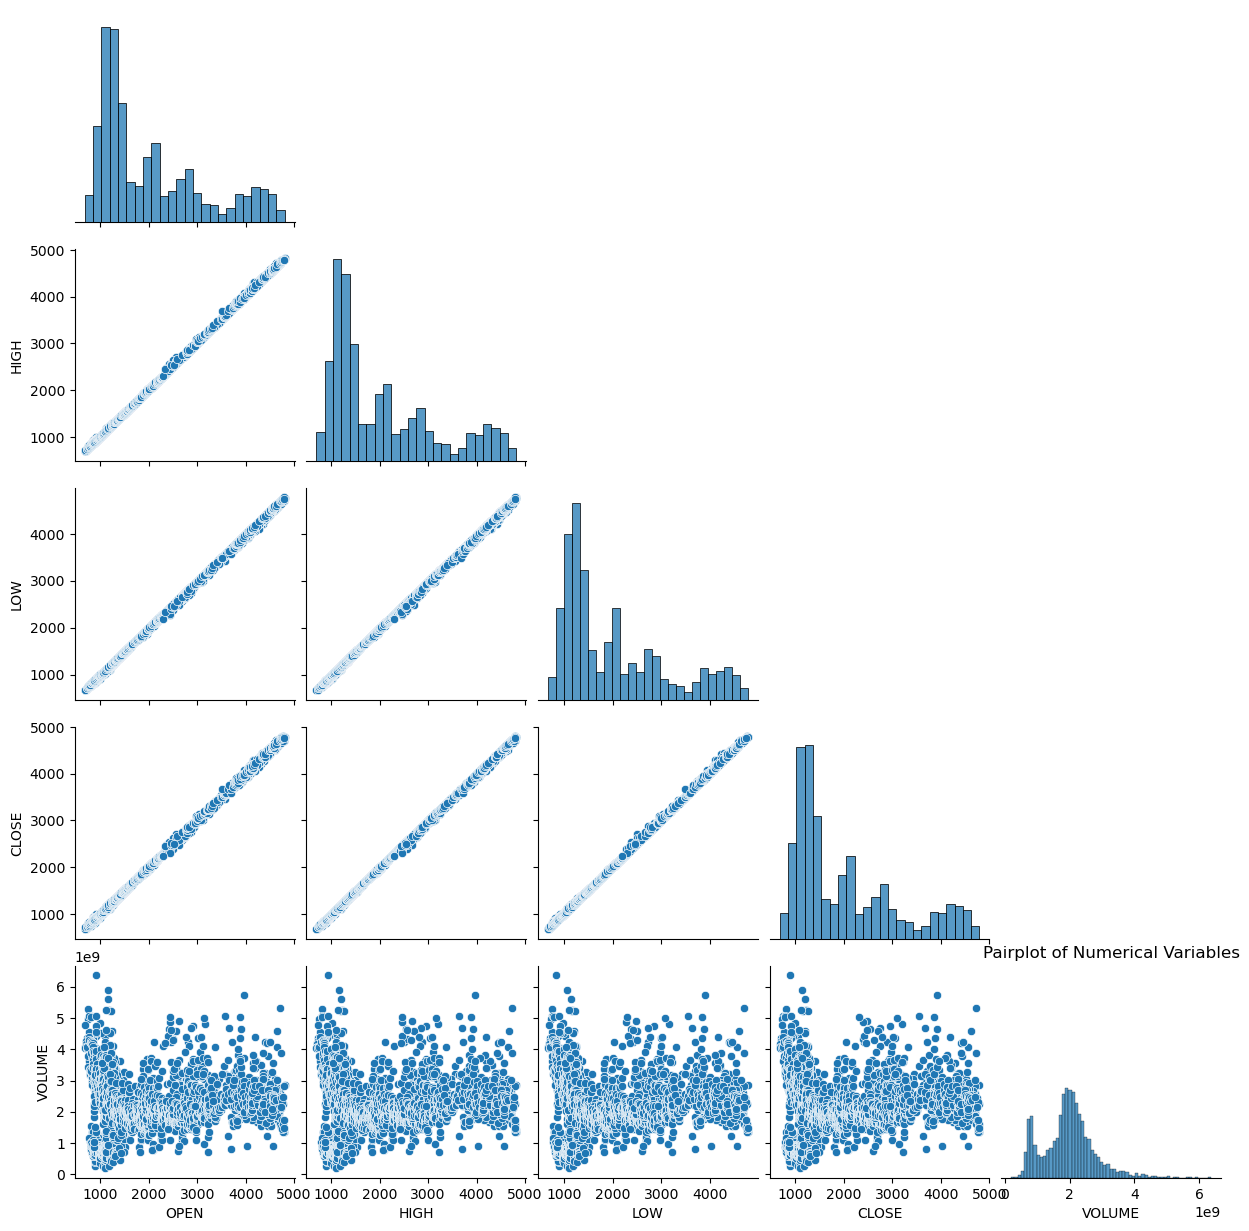

In [5]:
# Pairplot to visualize relationships between numerical variables
sns.pairplot(df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']], corner=True)
plt.title('Pairplot of Numerical Variables')
plt.show()

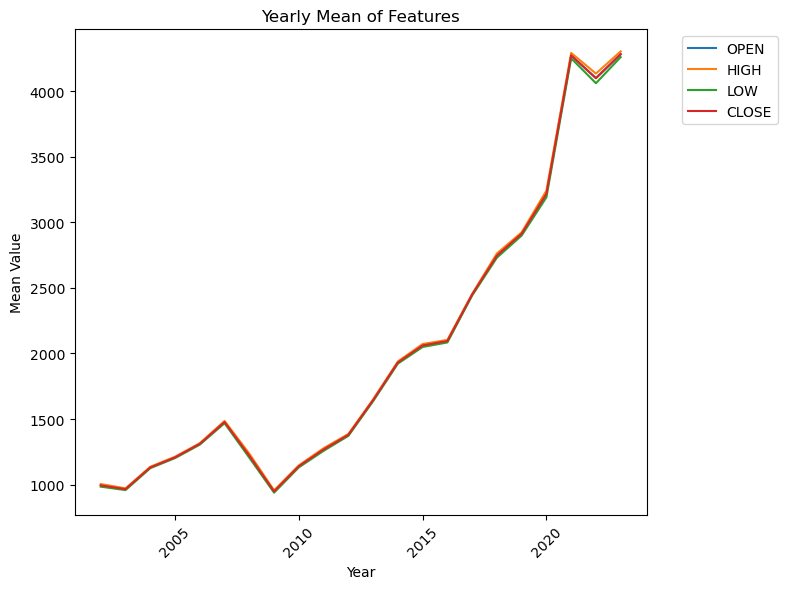

In [6]:
df_A = df.copy()
df_A['DATE'] = pd.to_datetime(df_A['DATE'])

# Extract year from the 'DATE' column
df_A['Year'] = df_A['DATE'].dt.year

# Aggregate data by year and compute the mean for each feature
yearly_data = df_A[['Year','OPEN', 'HIGH', 'LOW', 'CLOSE']].groupby('Year').mean()

# Reset index to have 'Year' as a regular column
yearly_data.reset_index(inplace=True)

# Melt the DataFrame to have a single x-axis for all features
melted_yearly_data = yearly_data.melt(id_vars=['Year'], var_name='Feature', value_name='Mean Value')

# Create a line plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=melted_yearly_data, x='Year', y='Mean Value', hue='Feature')
plt.title('Yearly Mean of Features')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

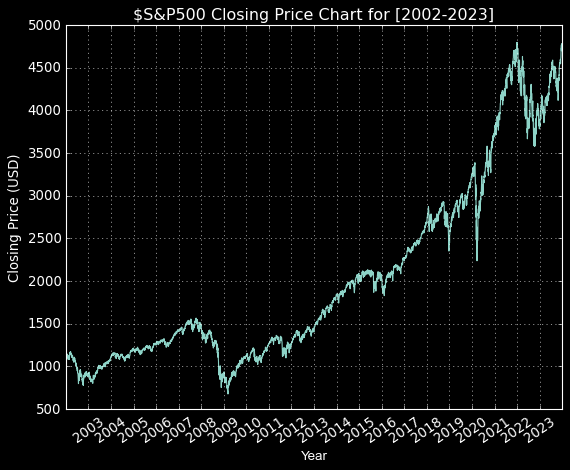

In [7]:
# create the font object
font = fm.FontProperties(family='Arial', size=12)

# Assign ticker symbol and data interval
symbol = 'S&P500'
startDate = '2001-12-31'
endDate = '2024-01-01'

# Convert 'date' column to datetime if it's not already in datetime format
df_plot = df.copy()
df_plot = df_plot[np.logical_and(df_plot['DATE'] <= endDate, df_plot['DATE'] > startDate)]
df_plot['DATE'] = pd.to_datetime(df_plot['DATE'])
#years = df_plot['DATE'].dt.year  # Extract years from the 'date' column
#years_ticks = np.arange(years.iloc[0], years.iloc[-1] + 1 ) #just the unique year numbers
#years_ticks = np.unique(years)


# Plotting closing price of the stock with respect to time
plt.style.use('classic')
plt.style.use('dark_background')
plt.plot(df_plot['DATE'], df_plot['CLOSE'])  


# Set x-axis tick format to display only years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))

# Adjust tick frequency if needed
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# plt.plot(data['Close'],'-o')  # For marking every datapoint 
plt.xlabel('Year', fontproperties=font)
plt.ylabel('Closing Price (USD)')
plt.title(f'${symbol} Closing Price Chart for [2002-2023]')
plt.xticks(rotation=35)  # For readability of time labels in x-axis (rotated by 35 degrees)
plt.grid(True,linestyle='dotted',)  # False for closing grids
#plt.savefig("figs/closingPrice_"+str(symbol)+str(startDate)+str(endDate)+".png")  # Save plot as indicated directory with name specified
plt.show()

In [8]:
#Simple Moving Avarage 
window_size = 15
#SMA Signal = Pt(current price as close price) - SMA
df['SMA'] =  df['CLOSE'].rolling(window=window_size).mean()
df['SMA_signal'] = df['CLOSE'] - df['SMA']

In [9]:
#Simple Moving Average over 50 days
SMA_50 = df['CLOSE'].rolling(window=50).mean()
#Simple Moving Average over 200 days
SMA_200 = df['CLOSE'].rolling(window=200).mean()

# death cross occurs when the 50-day SMA crosses below the 200-day SMA. This is considered a bearish signal, indicating that further losses are in store. 
# The golden cross occurs when a short-term SMA breaks above a long-term SMA. Reinforced by high trading volumes, this can signal further gains are in store.

In [10]:
# Create traces for each plot
trace_close = go.Scatter(x=df_plot['DATE'], y=df_plot['CLOSE'], mode='lines', name='Closing Price')
trace_sma = go.Scatter(x=df_plot['DATE'], y=df['SMA'], mode='lines', name='SMA_15')
trace_sma_50 = go.Scatter(x=df_plot['DATE'], y=SMA_50, mode='lines', name='SMA_50')
trace_sma_200= go.Scatter(x=df_plot['DATE'], y=SMA_200, mode='lines', name='SMA_200')
trace_sma_S= go.Scatter(x=df_plot['DATE'], y=df['SMA_signal'], mode='lines', name='SMA_Signal')

# Create layout
layout = go.Layout(
    title='Closing Price and Volume',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Value in USD'),
    hovermode='x'  # Show closest data point on hover
)

# Create figure and add traces
fig = go.Figure(data=[trace_close, trace_sma, trace_sma_50, trace_sma_200, trace_sma_S], layout=layout)

# Show interactive plot
fig.show()

In [11]:
#Weighted Moving Average
def calculate_wma(data, window):
    weights = np.arange(1, window + 1)
    wma = data.rolling(window=window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return wma

In [12]:

# Define the window size for WMA calculation
window_size = 15

# Calculate WMA with the specified window size
df['WMA'] = calculate_wma(df['CLOSE'], window_size)

df['WMA_signal'] = df['CLOSE'] - df['WMA']

In [13]:

# Define the window size for EMA calculation
window_size = 15

# Calculate EMA with the specified window size
#α = 2 / (N + 1)
df['EMA'] = df['CLOSE'].ewm(span=window_size).mean()

df['EMA_signal'] = df['CLOSE'] - df['EMA']

In [14]:
#Moving Average Convergence Divergence (MACD)
# Define periods for short-term and long-term EMAs
short_period = 12
long_period = 26
signal_line_span = 9

# Calculate short-term EMA
short_ema = df['CLOSE'].ewm(span=short_period, adjust=False).mean()

# Calculate long-term EMA
long_ema = df['CLOSE'].ewm(span=long_period, adjust=False).mean()

# Calculate MACD line
macd_line = short_ema - long_ema

# Calculate Signal line (typically 9-period EMA of MACD line)
signal_line = macd_line.ewm(span=signal_line_span, adjust=False).mean()

# Calculate MACD signal
df['macd_signal'] = macd_line - signal_line

In [15]:
# Define periods for calculating highest high and lowest low
window_size = 14

# Calculate highest high and lowest low over the period
HH = df['HIGH'].rolling(window=window_size).max()
LL = df['LOW'].rolling(window=window_size).min()

# Calculate %K line for Fast Stochastic Oscillator
df['K_Fast'] = 100 * ((df['CLOSE'] - LL) / (HH - LL))

# Calculate %D line for Fast Stochastic Oscillator (typically a 3-period SMA of %K)
period_d_fast = 3
df['D_Fast'] = df['K_Fast'].rolling(window=period_d_fast).mean()

# Calculate %K line for Slow Stochastic Oscillator
# This is not a feture as suggested by the article 
period_slow = 3
df['K_Slow'] = df['K_Fast'].rolling(window=period_slow).mean()

# Calculate %D line for Slow Stochastic Oscillator (typically a 3-period SMA of %K_Slow)
period_d_slow = 3
df['D_Slow'] = df['K_Slow'].rolling(window=period_d_slow).mean()

In [16]:
#Need to validate this code 
#Relative Strength Index (RSI)
window_size = 14

# Calculate price changes
Price_Change = df['CLOSE'].diff()

# Calculate gains and losses
Gain = np.where(Price_Change > 0, Price_Change, 0)
Loss = np.where(Price_Change < 0, abs(Price_Change), 0)

# Calculate average gain and average loss over the period
Avg_Gain = pd.Series(Gain).rolling(window=window_size, min_periods=1).mean()
Avg_Loss = pd.Series(Loss).rolling(window=window_size, min_periods=1).mean()

# Calculate Relative Strength (RS)
RS = Avg_Gain / Avg_Loss

# Calculate RSI
df['RSI'] = 100 - (100 / (1 + RS))

In [17]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import LinearAxis, Range1d
from bokeh.layouts import gridplot

# Calculate MACD
exp12 = df_plot['CLOSE'].ewm(span=12, adjust=False).mean()
exp26 = df_plot['CLOSE'].ewm(span=26, adjust=False).mean()
macd = exp12 - exp26
signal = macd.ewm(span=9, adjust=False).mean()

# Calculate RSI
delta = df_plot['CLOSE'].diff()
gain = (delta.where(delta > 0, 0)).ewm(span=14).mean()
loss = (-delta.where(delta < 0, 0)).ewm(span=14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))

# Create Bokeh figure
p1 = figure(x_axis_type='datetime', width=800, height=300, title='OHLC')


# Plot OHLC
p1.segment(df_plot['DATE'], df_plot['HIGH'], df_plot['DATE'], df_plot['LOW'], line_color='black')
p1.vbar(df_plot['DATE'], 0.5, df_plot['OPEN'], df_plot['CLOSE'], fill_color='green', line_color='black')

# Plot MACD on a separate y-axis
p2 = figure(x_axis_type='datetime', width=800, height=200, title='MACD')
p2.line(df_plot['DATE'], macd, color='blue', legend_label='MACD')
p2.line(df_plot['DATE'], signal, color='orange', legend_label='Signal')

p3 = figure(x_axis_type='datetime', width=800, height=200, title='RSI')
p3.line(df_plot['DATE'], rsi, color='green', legend_label='RSI')

# Combine plots into a grid
grid = gridplot([[p1], [p2], [p3]])

# Show plot
output_file('ohlc_macd_rsi.html')
show(grid)


In [18]:
# Define period for WPR calculation
window_size = 14

# Calculate highest high and lowest low over the period
Highest_High = df['HIGH'].rolling(window=window_size).max()
Lowest_Low = df['LOW'].rolling(window=window_size).min()

# Calculate Williams %R
df['WPR'] = (Highest_High - df['CLOSE']) / (Highest_High - Lowest_Low) * -100


In [19]:
def calculate_bollinger_bands(df, window=20, num_std_dev=2): #20,2 Typiclly used 
    # Calculate the rolling mean and standard deviation
    rolling_mean = df['Typical Price'].rolling(window=window).mean()
    rolling_std = df['Typical Price'].rolling(window=window).std()
    
    # Calculate upper and lower bands
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    
    return upper_band, lower_band


In [20]:
# Create a new column for the closing price
df['Typical Price'] = (df['LOW'] + df['HIGH'] + df['CLOSE']) / 3.0

# Calculate Bollinger Bands
upper_band, lower_band = calculate_bollinger_bands(df)

# Add the bands to the DataFrame
df['Upper Band'] = upper_band
df['Lower Band'] = lower_band

# Add the diff to the DataFrame
df['Bollinger Diff'] = df['Upper Band'] - df['Lower Band'] 

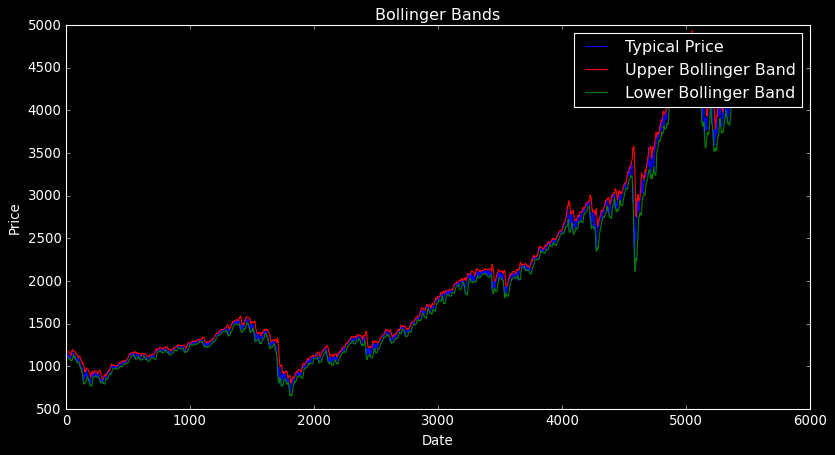

In [21]:
# Plotting

plt.figure(figsize=(12,6))
plt.plot(df['Typical Price'], label='Typical Price', color='blue')
plt.plot(df['Upper Band'], label='Upper Bollinger Band', color='red')
plt.plot(df['Lower Band'], label='Lower Bollinger Band', color='green')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [22]:
def calculate_obv(df):
    obv = [0]  # Initialize OBV with 0
    prev_close = df.iloc[0]['CLOSE']  # Get the closing price of the first day
    
    for i in range(1, len(df)):
        curr_close = df.iloc[i]['CLOSE']  # Get the closing price of the current day
        prev_obv = obv[-1]  # Get the previous OBV value
        
        if curr_close > prev_close:
            obv.append(prev_obv + df.iloc[i]['VOLUME'])
        elif curr_close < prev_close:
            obv.append(prev_obv - df.iloc[i]['VOLUME'])
        else:
            obv.append(prev_obv)
        
        prev_close = curr_close  # Update previous close for next iteration
    
    return obv

In [23]:
# Calculate OBV
obv_values = calculate_obv(df)

# Add OBV values to the DataFrame
df['OBV'] = obv_values

In [24]:
df.head()

,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,discrete_return,SMA,SMA_signal,WMA,...,D_Fast,K_Slow,D_Slow,RSI,WPR,Typical Price,Upper Band,Lower Band,Bollinger Diff,OBV
0,2002-01-02,1148.08,1154.67,1136.23,1154.67,650555556.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1148.523333,NaN,NaN,NaN,0.000000e+00
1,2002-01-03,1154.67,1165.27,1154.01,1165.27,777166667.0,0.009180,NaN,NaN,NaN,...,NaN,NaN,NaN,100.000000,NaN,1161.516667,NaN,NaN,NaN,7.771667e+08
2,2002-01-04,1165.27,1176.55,1163.42,1172.51,840555556.0,0.006213,NaN,NaN,NaN,...,NaN,NaN,NaN,100.000000,NaN,1170.826667,NaN,NaN,NaN,1.617722e+09
3,2002-01-07,1172.51,1176.97,1163.55,1164.89,726833333.0,-0.006499,NaN,NaN,NaN,...,NaN,NaN,NaN,70.070699,NaN,1168.470000,NaN,NaN,NaN,8.908889e+08
4,2002-01-08,1164.89,1167.60,1157.46,1160.71,699333333.0,-0.003588,NaN,NaN,NaN,...,NaN,NaN,NaN,60.188934,NaN,1161.923333,NaN,NaN,NaN,1.915556e+08


In [26]:
# features DF
# Select the columns from index 7 onwards as features
df_features = df.iloc[:, 6:].copy()

In [27]:
#Transformation Function
# X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

def feature_transform(x):
    max_x = np.max(x)
    min_x = np.min(x)

    x_transformed = (x - min_x)/(max_x - min_x)*2 -1

    return x_transformed

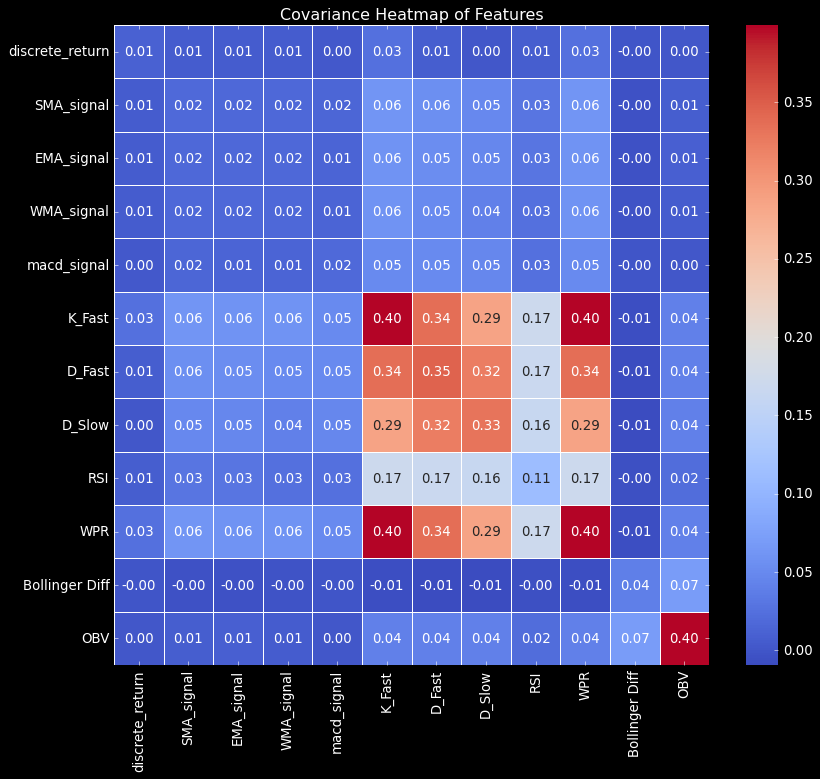

In [29]:
#Calculating the Heat Map:
# Data Scaling: Covariance is sensitive to the scale of the variables.
# If the features have different scales, the covariance values might be influenced by the magnitude of the values rather than the actual relationships.

# High Dimensionality: With a small number of features (5 in this case), 
# it's possible that other features not included in the selection play a significant role in relationships and patterns within the dataset.

# Cut the NAN data
df_features = df_features.iloc[20:]

# Transform features 
df_features_1 = df_features.apply(feature_transform)

# take a small number of features
df_features_1 = df_features_1[['discrete_return', 'SMA_signal', 'EMA_signal', 'WMA_signal', 'macd_signal', 'K_Fast', 'D_Fast', 'D_Slow', 'RSI', 'WPR', 'Bollinger Diff', 'OBV']]

# Calculate the covariance matrix
cov_matrix = df_features_1.cov()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Covariance Heatmap of Features')
plt.show()

In [36]:
# we can see that some of the features are correlated with each other but not with 
# the target variable, it suggests potential multicollinearity among the features. 
# Multicollinearity can cause issues such as inflated standard errors of coefficients, difficulty in 
# interpreting the coefficients, and instability in model predictions

# To address multicollinearity, you can consider the following approaches:
# 1. Feature Selection: Remove one of the correlated features from each pair of highly correlated features.
# You can do this based on domain knowledge or by using automated feature selection techniques such as recursive feature elimination (RFE), 
# L1 regularization (Lasso regression), or feature importance from tree-based models.

# 2. Dimensionality Reduction: Use dimensionality reduction techniques such as Principal Component Analysis (PCA) 
#to transform the original features into a lower-dimensional space of uncorrelated variables (principal components). 
#This can help mitigate multicollinearity while retaining most of the variance in the data.

# 3. Feature Engineering: Create new features that capture the essence of the correlated features without
# the multicollinearity issue. For example, you could create interaction terms, polynomial features, or derive new features based on domain knowledge.

# 4.Regularization: Apply regularization techniques such as L1 (Lasso) or L2 (Ridge) 
# regularization in linear models to penalize large coefficients and encourage sparse solutions.
#  Regularization can help mitigate the impact of multicollinearity by shrinking the coefficients of correlated features.

# 5.Tree-Based Models: If you plan to use tree-based models like Random Forest or Gradient Boosting Machines,
# multicollinearity is less of a concern because these models are robust to correlated features. 
# However, it's still important to monitor feature importance and potentially remove redundant features to improve interpretability and
# reduce model complexity.

# 6. VIF (Variance Inflation Factor): Calculate the VIF for each feature, which measures how much the variance of an estimated regression coefficient increases if your predictors are correlated.
# Features with high VIF values (typically above 5 or 10) may indicate multicollinearity issues and could be considered for removal.
# By addressing multicollinearity, you can improve the stability and interpretability of your machine learning models and potentially enhance their predictive performance.



     SMA_signal  EMA_signal  WMA_signal  macd_signal    K_Fast    D_Fast  \
100    0.328272    0.411443    0.351913     0.030031 -0.122242  0.246869   
101    0.306674    0.397141    0.335144     0.010276 -0.477700 -0.139309   
102    0.302975    0.395172    0.333326    -0.004749 -0.591573 -0.408959   
103    0.310630    0.408303    0.348328    -0.010277 -0.497438 -0.535209   
104    0.242631    0.341345    0.276390    -0.039781 -0.976608 -0.703087   

       D_Slow       RSI       WPR  Bollinger Diff       OBV  
100  0.333182  0.094397 -0.122242       -0.938706 -0.955061  
101  0.172166 -0.164607 -0.477700       -0.937745 -0.956595  
102 -0.095274 -0.090053 -0.591573       -0.933876 -0.958418  
103 -0.358950  0.054550 -0.497438       -0.933332 -0.956608  
104 -0.549027 -0.272199 -0.976608       -0.924111 -0.958484  
